In [42]:
import torch
import time
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#if device.type == 'cuda':
#    print(torch.cuda.get_device_name(0))
#    print('Memory Usage:')
#    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
#    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda


In [43]:
#Definindo os 2 dataset
#1º parâmetros - root, aonde o dataset está localizado
#2º parâmetro - Se for true, cria um dataset parcial apenas para treino, caso false, cria um para teste
#transforms.Compose - cria uma sucessão de transformações a serem feitas
#transforms.ToTensor - converte o data para um tensor
train = datasets.MNIST("", train=True, download=True, transform= transforms.Compose([transforms.ToTensor()]))

test = datasets.MNIST("", train=False, download=True, transform= transforms.Compose([transforms.ToTensor()]))

In [44]:
#Carregando o dataset no torch
#1º - Dataset de onde iremos carregar o data
#2º - Quantas amostras por batch desejamos carregar
#shuffle - ter o data todo bagunçado a capa epoch
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

tensor(0)
torch.Size([1, 28, 28])


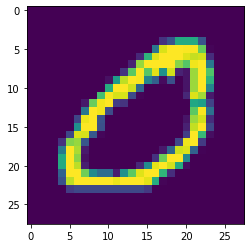

In [45]:
#for data in trainset:
#    print(data)
#    break

#O data [0][0] irá pegar a imagem no indice 1
#O data [1][0] pegará o valor referente ao dígito desenhado na imagem de indice 1
x,y = data[0][0], data[1][0]
print(y)
#Vamos perceber que vai mostrar que a imagem tem dimensões (1, 28, 28)
#Uma imagem RGB passou para colorida, que passou para um tensor flattened
print(x.shape)

#Para redimensionarmos um tensor, usamos a função view()
#Vamos redimensionar para 2 dimensões, ambas de 28 unidades
plt.imshow(x.view(28,28))
plt.show()

In [46]:
#É sempre bom fazer um balanceamento em seu dataset. Por exemplo, se em seu dataset tiver maior parte das fotos do número 3, a neural network vai achar o caminho mais fácil para fazer um predict deste 3, porém ao fazer predict de outro número, terá maior chance de erro. A sua loss function vai variar infinitamente
total = 0
#Criando um dicionário para cada número: N1 : N2 -> N1= número do dataset, N2 = quantidade de vezes que aparece
counter_dict = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}

for data in trainset:
    Xs, Ys = data
    for y in Ys:
        counter_dict[int(y)] += 1
        total+=1
print(counter_dict)

#Pegando a porcentagem de cada número em relação ao dataset inteiro
for i in counter_dict:
    print(f"{i}: {counter_dict[i]/total*100}")

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
0: 9.871666666666666
1: 11.236666666666666
2: 9.93
3: 10.218333333333334
4: 9.736666666666666
5: 9.035
6: 9.863333333333333
7: 10.441666666666666
8: 9.751666666666667
9: 9.915000000000001


In [47]:
#Criando a neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #Criando uma fully connected - parâmetros= tamanho da flattened entrando, e tamanho da flattened saindo, no nosso caso, as imagens são 28x28
        #No caso, ele colocou (64,64) porque quis, e no final (64,10) porque vão sair 10 classes (os 10 números)
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)

    #Esse método dirá como a input x irá realizar o feedfoward por entre as hidden layers
    def forward(self,x):
        #Porém, como não sabemos como será a saída de cada hidden layer, vamos usar a função de ativação para, além de retirar a linearidade da entrada, colocarmos a saída da hidden layer em um intervalo conhecido (No caso do Relu, de 0 até infinito)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        #Como durante a neural network a dimensão será continua, ela saíra em dimensão 1
        return F.log_softmax(x, dim=1)

#Chamando a classe da sua NeuralNetwork
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


In [48]:
#Criando uma matriz Tensor de 28x28
X = torch.rand((28,28))
#Dando flatten na matriz
#O -1 dirá que X é em um shape desconhecido, logo, será aceito QUALQUER dimensão, meio que se não importasse
X = X.view(-1,28,28)

In [49]:
#Criando o loss e o optmizer da sua rede neural
import torch.optim as optim
#1º paramâmetro - Você passa "O que dá pro optimizer melhorar?"
#2º parâmetro - learning ratio, com um lr grande, você vai tomar grandes variações de x na Cost Function, não conseguindo achar o mínimo geral da função. Com um lr pequeno você trava nos mínimos locais
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [50]:
#Setando as epochs
Epochs = 3

for epochs in range(Epochs):
    for data in trainset:
        #Data é um batch de imagens e sua respectivas designações
        X, y = data
        #zero_grad() limpa todos os gradientes antigos calculados por conta do backward()
        net.zero_grad()
        #Passando as imagens para a rede neural realizar o predict do treinamento
        output = net(X.view(-1, 28*28))
        #Calculando a loss no predict feito. Para uma saída que possui um valor apenas, use o nll_loss, caso a saída seja um vetor, use o cross_entropy
        loss = F.nll_loss(output,y)
        #Com o loss pego, o backward irá realizar a variação de loss por x, como uma derivada, a fim de encontrar o menor valor
        loss.backward()
        #O step irá atualizar os parâmetros da sua rede neural
        optimizer.step()
    print("Loss: ",loss)

Loss:  tensor(1.0851, grad_fn=<NllLossBackward>)
Loss:  tensor(0.3730, grad_fn=<NllLossBackward>)
Loss:  tensor(0.0082, grad_fn=<NllLossBackward>)


In [51]:
correct = 0
total = 0
#Para validar o nosso treinamento, não iremos precisar calcular nenhum gradiente, logo, com a função no_grad retiramos o cálculo de gradientes. Não queremos otimizar a Neural Network
with torch.no_grad():
    for data in trainset:
        X, y = data
        output = net(X.view(-1,28*28))
        #Aqui ele irá pegar as predições feitas pela rede neural(i) e enumera-las(idx)
        for idx, i in enumerate(output):
            #Dentre o vetor de predição que a neural networkd soltará, o argmax() vai pegar a de maior valor (a de maior porcentagem de chance), e irá comparar com 
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
print("Accuracy: ",round(correct/total,6))

Accuracy:  0.980217


tensor(1)


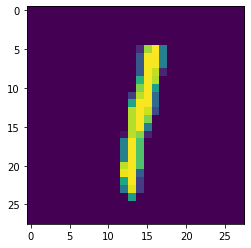

In [54]:
print(torch.argmax(net(X[1].view(-1,28*28))))
plt.imshow(X[1].view(28,28))
plt.show()